# COMP3115 Exploring COVID-19 data from `data.gov.hk` with Analysis and Visualization

During the pandemic, the government of Hong Kong has been publishing a lot of data on the COVID-19 situation. The data is available at [data.gov.hk](https://data.gov.hk/en-datasets?order=popularity&file-content=no). At that time the data is updated daily, and the data is available in many different format like CSV, JSON and XML.


In [77]:
import sys

!{sys.executable} -m pip install requests pandas numpy seaborn tqdm scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 57.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 43.5 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/Cellar/ipython/8.4.0/libexec/bin/python3.10 -m pip install --upgrade pip' command.


In [2]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # for making progress bar

Matplotlib is building the font cache; this may take a moment.
Fontconfig warning: ignoring UTF-8: not a valid region tag


# Historical Data API for Data in Coronavirus Dsease (COVID-19)

This section is about how to obtain the data via the API provided by data.gov.hk Please click on [this](https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent) link to see the dataset.

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9kYXRhLmdvdi5oay9lbi1kYXRhL2RhdGFzZXQvaGstZGgtY2hwc2ViY2Rkci1ub3ZlbC1pbmZlY3Rpb3VzLWFnZW50)




In the webpage, there is a date range to be selected by users to generate API links for retrieving the set of CSV data files. Each CSV file contains a single day data.

https://api.data.gov.hk/v1/historical-archive/list-file-versions?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fmode_of_detection_eng.csv&start=20220301&end=20220302

Above link is the AJAX url to generate the API links. The resulting JSON structure is not very comples, and could produce the following result.

Here is the result when you click on the `Next` button


https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fmode_of_detection_eng.csv&time=20220302-0937

You may notice that the API link is appended with `&time=20220302-0937` with the value of timestamp from previos JSON file to the csv file link.

Let's make a function to generate those API links. The earliest data is from `20200429`, and the latest data is from yesterday. We could use `strftime` to format time into corresponding date string.


In [3]:
from time import gmtime, strftime, time
import urllib.parse

def generateAPILinks(file_url = 'http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv', start = '20200101', end = strftime('%Y%m%d', gmtime(time() - 3600 * 24))):
  response = requests.get(f'https://api.data.gov.hk/v1/historical-archive/list-file-versions?url={urllib.parse.quote_plus(file_url)}&start={start}&end={end}')
  json = response.json()
  return [f'https://api.data.gov.hk/v1/historical-archive/get-file?url={urllib.parse.quote_plus(file_url)}&time=' + t for t in json['timestamps']]

In [4]:
urls = generateAPILinks()
len(urls)

703

In [5]:
urls[0]

'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fenhanced_sur_covid_19_eng.csv&time=20200404-0917'

## Latest Local Situation of COVID-19

Let's try to get the latest local situation of COVID-19 with the helper function that we have just created and assign it to a variable `latest_local_situation`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [6]:
enhanced_sur_covid_19_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv')
len(enhanced_sur_covid_19_urls)

703

In [7]:
pd.read_csv(enhanced_sur_covid_19_urls[0]).head(5)

,Case no.,Report date,Date of onset,Gender,Age,Name of hospital admitted,Hospitalised/Discharged/Deceased,HK/Non-HK resident,Case classification*,Confirmed/probable
0,1,23/01/2020,21/01/2020,M,39,Princess Margaret Hospital,Discharged,Non-HK resident,Imported,Confirmed
1,2,23/01/2020,18/01/2020,M,56,Princess Margaret Hospital,Discharged,HK resident,Imported,Confirmed
2,3,24/01/2020,20/01/2020,F,62,Princess Margaret Hospital,Discharged,Non-HK resident,Imported,Confirmed
3,4,24/01/2020,23/01/2020,F,62,Princess Margaret Hospital,Discharged,Non-HK resident,Imported,Confirmed
4,5,24/01/2020,23/01/2020,M,63,Princess Margaret Hospital,Discharged,Non-HK resident,Imported,Confirmed


In [8]:
pd.read_csv(enhanced_sur_covid_19_urls[-1]).head(5)

,Case no.,Report date,Date of onset,Gender,Age,Name of hospital admitted,Hospitalised/Discharged/Deceased,HK/Non-HK resident,Classification*,Case status*
0,1,23/01/2020,21/01/2020,M,39,NaN,Discharged,Non-HK resident,Imported case,Confirmed
1,2,23/01/2020,18/01/2020,M,56,NaN,Discharged,HK resident,Imported case,Confirmed
2,3,24/01/2020,20/01/2020,F,62,NaN,Discharged,Non-HK resident,Imported case,Confirmed
3,4,24/01/2020,23/01/2020,F,62,NaN,Discharged,Non-HK resident,Imported case,Confirmed
4,5,24/01/2020,23/01/2020,M,63,NaN,Discharged,Non-HK resident,Imported case,Confirmed


## Latest Situation of Reported Cases of COVID-19 in Hong Kong

Let's try to get the latest situation of reported cases of COVID-19 in Hong Kong with the helper function that we have just created and assign it to a variable `latest_situation_reported_cases`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.

https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent/resource/dc602108-884a-4af3-bdf3-75b32fe8b5b3

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9kYXRhLmdvdi5oay9lbi1kYXRhL2RhdGFzZXQvaGstZGgtY2hwc2ViY2Rkci1ub3ZlbC1pbmZlY3Rpb3VzLWFnZW50L3Jlc291cmNlL2RjNjAyMTA4LTg4NGEtNGFmMy1iZGYzLTc1YjMyZmU4YjViMw==)

In [9]:
latest_situation_of_reported_cases_covid_19_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/latest_situation_of_reported_cases_covid_19_eng.csv')
len(latest_situation_of_reported_cases_covid_19_urls)

1047

In [10]:
latest_situation_of_reported_cases_covid_19_urls[0]

'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Flatest_situation_of_reported_cases_covid_19_eng.csv&time=20200404-0917'

In [11]:
pd.read_csv(latest_situation_of_reported_cases_covid_19_urls[0]).head(5)

,As of date,As of time,Number of confirmed cases,Number of ruled out cases,Number of cases still hospitalised for investigation,Number of cases fulfilling the reporting criteria,Number of death cases,Number of discharge cases,Number of probable cases
0,08/01/2020,12:00,0,21,17,38,0,0,0
1,09/01/2020,12:00,0,25,23,48,0,0,0
2,10/01/2020,12:00,0,31,23,54,0,0,0
3,11/01/2020,12:00,0,46,15,61,0,0,0
4,12/01/2020,12:00,0,51,16,67,0,0,0


In [12]:
pd.read_csv(latest_situation_of_reported_cases_covid_19_urls[-1]).tail(5)

,As of date,As of time,Number of confirmed cases,Number of ruled out cases,Number of cases still hospitalised for investigation,Number of cases fulfilling the reporting criteria,Number of death cases,Number of discharge cases,Number of probable cases,Number of hospitalised cases in critical condition,Number of cases tested positive for SARS-CoV-2 virus by nucleic acid tests,Number of cases tested positive for SARS-CoV-2 virus by rapid antigen tests,Number of positive nucleic acid test laboratory detections,Number of death cases related to COVID-19
1135,16/02/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.0,2.0
1136,17/02/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.0,2.0
1137,18/02/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.0,5.0
1138,19/02/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.0,2.0
1139,20/02/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.0,3.0


## List of flights/trains/ships/vehicles taken by cases tested positive for SARS-CoV-2 virus in the past 14 days

Let's get the list of flights/trains/ships/vehicles taken by cases tested positive for SARS-CoV-2 virus in the past 14 days with the helper function that we have just created and assign it to a variable `list_of_flights_trains_ships_vehicles`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [13]:
flights_trains_list_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/flights_trains_list_eng.csv')
len(flights_trains_list_urls)

1012

In [14]:
flights_trains_list_urls[0]

'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fflights_trains_list_eng.csv&time=20200203-0913'

In [15]:
pd.read_csv(flights_trains_list_urls[0]).head(5)

,Flight/Train/Ship number,Departure & arrival,Date of travel
0,Air China Flight CA8279,Wuhan to Shenzhen,19/01/2020
1,High Speed Rail G1013,Wuhan to Shenzhenbei,19/01/2020
2,High Speed Rail G6543,Shenzhenbei to Hong Kong,19/01/2020
3,Cathay Dragon KA853,Wuhan to Hong Kong,19/01/2020
4,Cathay Pacific Airways CX500,Hong Kong to Japan,19/01/2020


In [16]:
pd.read_csv(flights_trains_list_urls[-1]).head(5)

,Flight/Train/Ship number,Departure & arrival,Date of travel,Related cases,Seat Number (if known)
0,AI314,New Delhi,22/12/2022,NaN,Unknown
1,CX750,Bangkok,22/12/2022,NaN,Unknown
2,CX766,Ho Chi Minh City,22/12/2022,NaN,Unknown
3,CX495,Taipei,22/12/2022,NaN,Unknown
4,AI314,New Delhi,22/12/2022,NaN,22D


## List of buildings of the home confinees under mandatory home quarantine according to Cap. 599C of Hong Kong Laws

Let's get the list of buildings of the home confinees under mandatory home quarantine according to Cap. 599C of Hong Kong Laws with the helper function that we have just created and assign it to a variable `list_of_buildings_of_home_confinees`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [17]:
home_confinees_tier2_building_list_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/home_confinees_tier2_building_list.csv')
len(home_confinees_tier2_building_list_urls)

9

In [18]:
home_confinees_tier2_building_list_urls

['https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fhome_confinees_tier2_building_list.csv&time=20200229-0918',
 'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fhome_confinees_tier2_building_list.csv&time=20200302-0916',
 'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fhome_confinees_tier2_building_list.csv&time=20200304-0919',
 'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fhome_confinees_tier2_building_list.csv&time=20200306-0917',
 'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fhome_confinees_tier2_building_list.csv&time=20200308-0918',
 'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fhome_confinees_tier2_building_list.csv&time=20200311-1020',
 'ht

In [19]:
pd.read_csv(home_confinees_tier2_building_list_urls[0]).head(5)

,編號 No.,區 District,地址 Address,家居檢疫最後日期 End Date of Home Quarantine Order
0,1,中西區 Central & Western,加多近山\nCADOGAN,27/02/2020
1,2,中西區 Central & Western,"西摩道11號福澤花園A座\nBLOCK A, THE FORTUNE GARDENS, NO...",27/02/2020
2,3,中西區 Central & Western,"花園道55號愛都大廈3座\nBLOCK 3, ESTORIL COURT, NO.55 GA...",27/02/2020
3,4,中西區 Central & Western,皇后大道西355-359號\nNO.355-359 QUEEN'S ROAD WEST,27/02/2020
4,5,中西區 Central & Western,泰成大廈\nTAI SHING BUILDING,27/02/2020


## Daily statistics on testing for COVID-19 in Hong Kong (English/Traditional Chinese)
Let's get the daily statistics on testing for COVID-19 in Hong Kong (English/Traditional Chinese) with the helper function that we have just created and assign it to a variable `daily_statistics_on_testing_for_covid_19`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [20]:
statistics_on_covid_19_testing_daily_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/statistics_on_covid_19_testing_daily.csv')
len(statistics_on_covid_19_testing_daily_urls)

2

In [21]:
statistics_on_covid_19_testing_daily_urls

['https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fstatistics_on_covid_19_testing_daily.csv&time=20200405-0948',
 'https://api.data.gov.hk/v1/historical-archive/get-file?url=http%3A%2F%2Fwww.chp.gov.hk%2Ffiles%2Fmisc%2Fstatistics_on_covid_19_testing_daily.csv&time=20200406-0918']

In [22]:
pd.read_csv(statistics_on_covid_19_testing_daily_urls[0])

,日期 Date,檢測數字 Number of tests
0,27/03/2020,4209
1,28/03/2020,2914
2,29/03/2020,2669
3,30/03/2020,3524
4,31/03/2020,4627


## Mode of detection of cases tested positive for SARS-CoV-2 virus in Hong Kong
Let's get the mode of detection of cases tested positive for SARS-CoV-2 virus in Hong Kong with the helper function that we have just created and assign it to a variable `mode_of_detection_of_cases_tested_positive_for_sars_cov_2_virus`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [23]:
mode_of_detection_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/mode_of_detection_eng.csv')
len(mode_of_detection_urls)

629

In [24]:
pd.read_csv(mode_of_detection_urls[0])

,Category number,Category name,Number of cases
0,1,Cases fulfilling the reporting criteria of COV...,344
1,2,Enhanced laboratory surveillance in public hos...,49
2,3,Enhanced surveillance at Accident and Emergenc...,127
3,4,Diagnosis / Enhanced surveillance in private h...,89
4,5,Medical surveillance / Contact tracing by the ...,187
5,6,Enhanced surveillance for asymptomatic inbound...,242


In [25]:
pd.read_csv(mode_of_detection_urls[-1])

,Category number,Category name,Number of cases,Number of cases in the past 4 weeks
0,1,Cases fulfilling the reporting criteria of COV...,336,0
1,2,Enhanced laboratory surveillance in public hos...,893,146
2,3,Enhanced surveillance at Accident and Emergenc...,6250,3555
3,4,Diagnosis / Enhanced surveillance in private h...,2054,661
4,5,Medical surveillance / contact tracing by Cent...,5919,657
5,6,Enhanced surveillance for asymptomatic inbound...,2138,116
6,7,Enhanced surveillance for persons with higher ...,44,17
7,8,Private testing for the targeted groups,98,0
8,9,Universal Community Testing Programme,32,0
9,10,Community testing centre,5666,3856


## Number of confines by types in the quarantine centres (English)
Let's get the number of confines by types in the quarantine centres (English) with the helper function that we have just created and assign it to a variable `number_of_confines_by_types_in_the_quarantine_centres`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [26]:
no_of_confines_by_types_in_quarantine_centres_urls = generateAPILinks('http://www.chp.gov.hk/files/misc/no_of_confines_by_types_in_quarantine_centres_eng.csv')
len(no_of_confines_by_types_in_quarantine_centres_urls)

918

In [27]:
pd.read_csv(no_of_confines_by_types_in_quarantine_centres_urls[0])

,As of date,As of time,Cumulative number of close contacts of confirmed cases,Cumulative number of non-close contacts,Current number of close contacts of confirmed cases,Current number of non-close contacts
0,24/04/2020,09:00,2819,1665,57,2
1,25/04/2020,09:00,2831,1665,63,2
2,26/04/2020,09:00,2835,1666,58,3
3,27/04/2020,09:00,2837,1667,54,4
4,28/04/2020,09:00,2837,1670,45,6


In [28]:
pd.read_csv(no_of_confines_by_types_in_quarantine_centres_urls[-1]).tail(5)

,As of date,As of time,Cumulative number of close contacts of confirmed cases,Cumulative number of non-close contacts,Current number of close contacts of confirmed cases,Current number of non-close contacts
941,24/12/2022,12:00,67508,17103,15,0
942,25/12/2022,12:00,67513,17103,10,0
943,26/12/2022,12:00,67514,17103,6,0
944,27/12/2022,12:00,67514,17103,3,0
945,28/12/2022,12:00,67517,17103,3,0


# Fetching data

Let's put them together to fetch all data. It's good to wrap the list with `tqdm` so that it will show a progress bar when running.


## Latest local situation of COVID-19

Let's wrap the data collection process in a loop in order to fetch all data and append to a single dataframe.

In [29]:
enhanced_sur_covid_19_df = pd.DataFrame()
for u in tqdm(enhanced_sur_covid_19_urls):
  enhanced_sur_covid_19_df = pd.concat([enhanced_sur_covid_19_df, pd.read_csv(u, index_col=0)])

  9%|███▉                                      | 65/703 [00:59<09:46,  1.09it/s]


KeyboardInterrupt: 

It's would be great to save a copy local, so that you won't lost the data.

In [ ]:
enhanced_sur_covid_19_df.to_csv('enhanced_sur_covid_19_eng.csv')

In [30]:
enhanced_sur_covid_19_df = pd.read_csv('enhanced_sur_covid_19_eng.csv', index_col=0)

/var/folders/9r/c_fmnct95pl7d82prlb4dr2971j9tk/T/ipykernel_17052/2112832104.py:1: DtypeWarning: Columns (2,4,5,8,9,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  enhanced_sur_covid_19_df = pd.read_csv('enhanced_sur_covid_19_eng.csv', index_col=0)


## Latest situation of reported cases of COVID-19 in Hong Kong
Let's get the latest situation of reported cases of COVID-19 in Hong Kong with the helper function that we have just created and assign it to a variable `latest_situation_of_reported_cases_of_covid_19_in_hong_kong`. The data is in CSV format, so we could use `pandas` to read the data into a dataframe.


In [65]:
latest_situation_of_reported_cases_covid_19_df = pd.DataFrame()
for u in tqdm(latest_situation_of_reported_cases_covid_19_urls):
  latest_situation_of_reported_cases_covid_19_df = pd.concat([latest_situation_of_reported_cases_covid_19_df, pd.read_csv(u)], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [10:56<00:00,  1.59it/s]


In [66]:
latest_situation_of_reported_cases_covid_19_df.to_csv('latest_situation_of_reported_cases_covid_19.csv')

/usr/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [53]:
latest_situation_of_reported_cases_covid_19_df = pd.read_csv('latest_situation_of_reported_cases_covid_19.csv', index_col=0)

## List of flights/trains/ships/vehicles taken by cases tested positive for SARS-CoV-2 virus in the past 14 days

In [69]:
flights_trains_list_df = pd.DataFrame()
for u in tqdm(flights_trains_list_urls):
  flights_trains_list_df = pd.concat([flights_trains_list_df, pd.read_csv(u)], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1012/1012 [13:02<00:00,  1.29it/s]


In [70]:
flights_trains_list_df.to_csv('flights_trains_list.csv')

In [71]:
flights_trains_list_df = pd.read_csv('flights_trains_list.csv', index_col=0)

/tmp/ipykernel_26565/1198249857.py:1: DtypeWarning: Columns (4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_trains_list_df = pd.read_csv('flights_trains_list.csv', index_col=0)


## Daily statistics on testing for COVID-19 in Hong Kong (English/Traditional Chinese)

In [72]:
statistics_on_covid_19_testing_daily_df = pd.DataFrame()
for u in tqdm(statistics_on_covid_19_testing_daily_urls):
  statistics_on_covid_19_testing_daily_df = pd.concat([statistics_on_covid_19_testing_daily_df, pd.read_csv(u)], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]


In [73]:
statistics_on_covid_19_testing_daily_df.to_csv('statistics_on_covid_19_testing_daily.csv')

In [74]:
statistics_on_covid_19_testing_daily_df = pd.read_csv('statistics_on_covid_19_testing_daily.csv', index_col=0)

## Mode of detection of cases tested positive for SARS-CoV-2 virus in Hong Kong

In [75]:
mode_of_detection_df = pd.DataFrame()
for u in tqdm(mode_of_detection_urls):
  # mode_of_detection_df = mode_of_detection_df.concat(pd.read_csv(u), ignore_index=True)
  singledaydf = pd.read_csv(u, index_col=1)
  singledaydf.drop(columns=['Category number'], inplace=True)
  if 'Number of cases in the past 4 weeks' in singledaydf.columns:
    singledaydf.drop(columns=['Number of cases in the past 4 weeks'], inplace=True)
  singledaydf.rename({'Number of cases':u[-13:-5]}, axis=1, inplace=True)
  mode_of_detection_df = pd.concat([mode_of_detection_df, singledaydf.T])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 629/629 [06:31<00:00,  1.61it/s]


In [76]:
mode_of_detection_df.to_csv('mode_of_detection.csv')

/usr/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [77]:
mode_of_detection_df = pd.read_csv('mode_of_detection.csv', index_col=0)

## Number of confines by types in the quarantine centres (English)

In [80]:
no_of_confines_by_types_in_quarantine_centres_df = pd.DataFrame()
for u in tqdm(no_of_confines_by_types_in_quarantine_centres_urls):
  no_of_confines_by_types_in_quarantine_centres_df = pd.concat([no_of_confines_by_types_in_quarantine_centres_df, pd.read_csv(u)], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [21:12<00:00,  1.39s/it]


In [82]:
no_of_confines_by_types_in_quarantine_centres_df.to_csv('no_of_confines_by_types_in_quarantine_centres.csv')

In [83]:
no_of_confines_by_types_in_quarantine_centres_df = pd.read_csv('no_of_confines_by_types_in_quarantine_centres.csv', index_col=0)

# Data Processing

## Latest local situation of COVID-19

In [37]:
enhanced_sur_covid_19_df = pd.read_csv('enhanced_sur_covid_19_eng.csv', index_col=0)
enhanced_sur_covid_19_df.info()

/var/folders/9r/c_fmnct95pl7d82prlb4dr2971j9tk/T/ipykernel_17052/798011519.py:1: DtypeWarning: Columns (2,4,5,8,9,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  enhanced_sur_covid_19_df = pd.read_csv('enhanced_sur_covid_19_eng.csv', index_col=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6287249 entries, 1 to 97097
Data columns (total 13 columns):
 #   Column                            Dtype 
---  ------                            ----- 
 0   Report date                       object
 1   Date of onset                     object
 2   Gender                            object
 3   Age                               object
 4   Name of hospital admitted         object
 5   Hospitalised/Discharged/Deceased  object
 6   HK/Non-HK resident                object
 7   Case classification*              object
 8   Confirmed/probable                object
 9   Date of onset                     object
 10  Classification*                   object
 11  Case status*                      object
 12  Unnamed: 10                       object
dtypes: object(13)
memory usage: 671.6+ MB


### Convert categorical value type

In [38]:
enhanced_sur_covid_19_df['Gender'] = enhanced_sur_covid_19_df['Gender'].astype('category')
enhanced_sur_covid_19_df['Name of hospital admitted'] = enhanced_sur_covid_19_df['Name of hospital admitted'].astype('category')
enhanced_sur_covid_19_df['Hospitalised/Discharged/Deceased'] = enhanced_sur_covid_19_df['Hospitalised/Discharged/Deceased'].astype('category')
enhanced_sur_covid_19_df['HK/Non-HK resident'] = enhanced_sur_covid_19_df['HK/Non-HK resident'].astype('category')
enhanced_sur_covid_19_df['Case classification*'] = enhanced_sur_covid_19_df['Case classification*'].astype('category')
enhanced_sur_covid_19_df['Gender'] = enhanced_sur_covid_19_df['Gender'].astype('category')

## Mode of detection of cases tested positive for SARS-CoV-2 virus in Hong Kong

Only 4 columns exsit in all the CSV files with 629 records. And some column name with typo making them seperated.

In [39]:
mode_of_detection_df = pd.read_csv('mode_of_detection.csv', index_col=0)

mode_of_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 20200429 to 20220303
Data columns (total 22 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Cases fulfilling the reporting criteria of COVID-19                                        629 non-null    int64  
 1   Enhanced laboratory surveillance in public hospitals                                       629 non-null    int64  
 2   Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics   549 non-null    float64
 3   Diagnosis / Enhanced surveillance in private hospitals and clinics                         629 non-null    int64  
 4   Medical surveillance / Contact tracing by the Centre for Health Protection                 66 non-null     float64
 5   Enhanced surveillance for asymptomatic

### Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics

Filling NAs in `Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics` using value from `Enhanced surveillance at  Accident and Emergency Departments / General Outpatient Clinics`.

In [40]:
help(np.where)

Help on function where in module numpy:

where(...)
    where(condition, [x, y], /)
    
    Return elements chosen from `x` or `y` depending on `condition`.
    
    .. note::
        When only `condition` is provided, this function is a shorthand for
        ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
        preferred, as it behaves correctly for subclasses. The rest of this
        documentation covers only the case where all three arguments are
        provided.
    
    Parameters
    ----------
    condition : array_like, bool
        Where True, yield `x`, otherwise yield `y`.
    x, y : array_like
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.
    
    Returns
    -------
    out : ndarray
        An array with elements from `x` where `condition` is True, and elements
        from `y` elsewhere.
    
    See Also
    --------
    choose
    nonzero : The function that is called when x an

In [41]:
mode_of_detection_df['Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics'] = np.where(
  mode_of_detection_df['Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics'].isna(),
  mode_of_detection_df['Enhanced surveillance at  Accident and Emergency Departments / General Outpatient Clinics'],
  mode_of_detection_df['Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics']
)
mode_of_detection_df[mode_of_detection_df['Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics'].isna()]

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Medical surveillance / Contact tracing by the Centre for Health Protection,Enhanced surveillance for asymptomatic inbound travelers,Others,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,...,Private testing for targeted high-risk groups,Universal Community Testing Programme,Private testing for targeted groups,Private testing for high-risk groups,Temporary testing centre,Private testing for the high-risk groups,Private testing for the targeted groups,Community testing centre,Medical surveillance / contact tracing by Centre for Health Protection,Pending


After that, we could drop the column with extra space.

In [42]:
mode_of_detection_df.drop(columns='Enhanced surveillance at  Accident and Emergency Departments / General Outpatient Clinics', inplace=True)
mode_of_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 20200429 to 20220303
Data columns (total 21 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   Cases fulfilling the reporting criteria of COVID-19                                       629 non-null    int64  
 1   Enhanced laboratory surveillance in public hospitals                                      629 non-null    int64  
 2   Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics  629 non-null    float64
 3   Diagnosis / Enhanced surveillance in private hospitals and clinics                        629 non-null    int64  
 4   Medical surveillance / Contact tracing by the Centre for Health Protection                66 non-null     float64
 5   Enhanced surveillance for asymptomatic inboun

### Medical surveillance / contact tracing by Centre for Health Protection

In [43]:
mode_of_detection_df.columns

Index(['Cases fulfilling the reporting criteria of COVID-19',
       'Enhanced laboratory surveillance in public hospitals',
       'Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics',
       'Diagnosis / Enhanced surveillance in private hospitals and clinics',
       'Medical surveillance / Contact tracing by the Centre for Health Protection',
       'Enhanced surveillance for asymptomatic inbound travelers', 'Others',
       'Medical surveillance / contact tracing by Centre for Health Protection',
       'Enhanced surveillance for persons with higher risk of exposure',
       'Private testing for the four high-risk groups*',
       'Private testing for the four high-risk groups',
       'Private testing for targeted high-risk groups',
       'Universal Community Testing Programme',
       'Private testing for targeted groups',
       'Private testing for high-risk groups', 'Temporary testing centre',
       'Private testing for the high-risk gro

The followings should be the same column with typo and different wording. Let's combine them together into ``

- `Medical surveillance / Contact tracing by the Centre for Health Protection`
- `Medical surveillance / contact tracing by Centre for Health Protection`
- `Medical surveillance / contact tracing by Centre for Health Protection ` (an extra space at the end)

In [44]:
mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection'] = np.where(
    mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection'].isna(),
    mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection '],
    mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection']
)
mode_of_detection_df.drop(columns='Medical surveillance / contact tracing by Centre for Health Protection ', inplace=True)

mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection'] = np.where(
    mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection'].isna(),
    mode_of_detection_df['Medical surveillance / Contact tracing by the Centre for Health Protection'],
    mode_of_detection_df['Medical surveillance / contact tracing by Centre for Health Protection']
)
mode_of_detection_df.drop(columns='Medical surveillance / Contact tracing by the Centre for Health Protection', inplace=True)

### Private testing for the high-risk groups

In [45]:
mode_of_detection_df[mode_of_detection_df['Private testing for the targeted groups'].isna()]

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Private testing for the four high-risk groups*,Private testing for the four high-risk groups,Private testing for targeted high-risk groups,Universal Community Testing Programme,Private testing for targeted groups,Private testing for high-risk groups,Temporary testing centre,Private testing for the high-risk groups,Private testing for the targeted groups,Community testing centre,Pending
20200429,344,49,127.0,89,242,NaN,187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200430,335,48,123.0,84,239,NaN,209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200501,334,48,123.0,84,239,NaN,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200502,333,48,122.0,85,241,NaN,211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200505,333,48,122.0,85,242,NaN,211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201029,336,540,1425.0,686,843,2.0,1368.0,18.0,NaN,60.0,NaN,32.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
20201030,336,540,1426.0,686,843,2.0,1370.0,18.0,NaN,60.0,NaN,32.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
20201031,336,540,1426.0,687,843,2.0,1376.0,18.0,NaN,60.0,NaN,32.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
20201101,336,540,1426.0,687,846,2.0,1376.0,18.0,NaN,60.0,NaN,32.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


Acorrding to https://www.coronavirus.gov.hk/eng/compulsory-testing.html#high-risk-groups, they are grouped together. Let's combine the followings into a single column `Private testing for the targeted groups`.

- `Private testing for the four high-risk groups*`
- `Private testing for the four high-risk groups`
- `Private testing for targeted high-risk groups`
- `Private testing for targeted groups`
- `Private testing for high-risk groups`
- `Private testing for the high-risk groups`
- `Private testing for the targeted groups`

In [46]:
mode_of_detection_df['Private testing for the targeted groups'] = np.where(
    mode_of_detection_df['Private testing for the targeted groups'].isna(),
    mode_of_detection_df['Private testing for the four high-risk groups*'],
    mode_of_detection_df['Private testing for the targeted groups']
)
mode_of_detection_df.drop(columns='Private testing for the four high-risk groups*', inplace=True)

mode_of_detection_df['Private testing for the targeted groups'] = np.where(
    mode_of_detection_df['Private testing for the targeted groups'].isna(), 
    mode_of_detection_df['Private testing for the four high-risk groups'], 
    mode_of_detection_df['Private testing for the targeted groups']
)
mode_of_detection_df.drop(columns='Private testing for the four high-risk groups', inplace=True)

mode_of_detection_df['Private testing for the targeted groups'] = np.where(
    mode_of_detection_df['Private testing for the targeted groups'].isna(),
    mode_of_detection_df['Private testing for targeted high-risk groups'],
    mode_of_detection_df['Private testing for the targeted groups']
)
mode_of_detection_df.drop(columns='Private testing for targeted high-risk groups', inplace=True)

mode_of_detection_df['Private testing for the targeted groups'] = np.where(
    mode_of_detection_df['Private testing for the targeted groups'].isna(), 
    mode_of_detection_df['Private testing for targeted groups'], 
    mode_of_detection_df['Private testing for the targeted groups']
)
mode_of_detection_df.drop(columns='Private testing for targeted groups', inplace=True)

mode_of_detection_df['Private testing for the targeted groups'] = np.where(
    mode_of_detection_df['Private testing for the targeted groups'].isna(), 
    mode_of_detection_df['Private testing for high-risk groups'], 
    mode_of_detection_df['Private testing for the targeted groups']
)
mode_of_detection_df.drop(columns='Private testing for high-risk groups', inplace=True)

mode_of_detection_df['Private testing for the targeted groups'] = np.where(
    mode_of_detection_df['Private testing for the targeted groups'].isna(), 
    mode_of_detection_df['Private testing for the high-risk groups'], 
    mode_of_detection_df['Private testing for the targeted groups']
)
mode_of_detection_df.drop(columns='Private testing for the high-risk groups', inplace=True)

Finally, we got following columns.

In [47]:
mode_of_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 20200429 to 20220303
Data columns (total 13 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   Cases fulfilling the reporting criteria of COVID-19                                       629 non-null    int64  
 1   Enhanced laboratory surveillance in public hospitals                                      629 non-null    int64  
 2   Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics  629 non-null    float64
 3   Diagnosis / Enhanced surveillance in private hospitals and clinics                        629 non-null    int64  
 4   Enhanced surveillance for asymptomatic inbound travelers                                  629 non-null    int64  
 5   Others                                       

### Replace NAs

In [48]:
mode_of_detection_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [49]:
mode_of_detection_df

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending
20200429,344,49,127.0,89,242,0.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0
20200430,335,48,123.0,84,239,0.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0
20200501,334,48,123.0,84,239,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0
20200502,333,48,122.0,85,241,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
20200505,333,48,122.0,85,242,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220227,336,882,6188.0,2011,2129,11.0,5931.0,59.0,32.0,0.0,98.0,5642.0,115626.0
20220228,336,883,6191.0,2013,2133,11.0,5934.0,59.0,32.0,0.0,98.0,5645.0,147969.0
20220301,336,884,6202.0,2015,2133,11.0,5932.0,57.0,32.0,0.0,98.0,5653.0,182417.0
20220302,336,891,6231.0,2038,2138,11.0,5923.0,49.0,32.0,0.0,98.0,5660.0,214960.0


### Convert index to date

In [50]:
mode_of_detection_df.index = pd.to_datetime(mode_of_detection_df.index.astype(str), format="%Y%m%d")

In [51]:
mode_of_detection_df.index

DatetimeIndex(['2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02',
               '2020-05-05', '2020-05-08', '2020-05-10', '2020-05-11',
               '2020-05-14', '2020-05-15',
               ...
               '2022-02-21', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03'],
              dtype='datetime64[ns]', length=629, freq=None)

## Latest situation of reported cases of COVID-19 in Hong Kong

### Use datetime as index

In [54]:
latest_situation_of_reported_cases_covid_19_df.index = latest_situation_of_reported_cases_covid_19_df['As of date'] + ' ' + latest_situation_of_reported_cases_covid_19_df['As of time']
latest_situation_of_reported_cases_covid_19_df.index

Index(['08/01/2020 12:00', '09/01/2020 12:00', '10/01/2020 12:00',
       '11/01/2020 12:00', '12/01/2020 12:00', '13/01/2020 12:00',
       '14/01/2020 12:00', '15/01/2020 12:00', '16/01/2020 12:00',
       '17/01/2020 12:00',
       ...
                      nan,                nan,                nan,
                      nan,                nan,                nan,
                      nan,                nan,                nan,
                      nan],
      dtype='object', length=641380)

### Dropping NA

In [55]:
latest_situation_of_reported_cases_covid_19_df = latest_situation_of_reported_cases_covid_19_df[latest_situation_of_reported_cases_covid_19_df.index.notnull()]

In [56]:
latest_situation_of_reported_cases_covid_19_df.index.unique()

Index(['08/01/2020 12:00', '09/01/2020 12:00', '10/01/2020 12:00',
       '11/01/2020 12:00', '12/01/2020 12:00', '13/01/2020 12:00',
       '14/01/2020 12:00', '15/01/2020 12:00', '16/01/2020 12:00',
       '17/01/2020 12:00',
       ...
       '17/07/2020 12:00', '18/07/2020 12:00', '19/07/2020 12:00',
       '13/7/2020 12:00', '14/7/2020 12:00', '15/7/2020 12:00',
       '16/7/2020 12:00', '17/7/2020 12:00', '18/7/2020 12:00',
       '19/7/2020 12:00'],
      dtype='object', length=388)

In [57]:
latest_situation_of_reported_cases_covid_19_df.index.unique()

Index(['08/01/2020 12:00', '09/01/2020 12:00', '10/01/2020 12:00',
       '11/01/2020 12:00', '12/01/2020 12:00', '13/01/2020 12:00',
       '14/01/2020 12:00', '15/01/2020 12:00', '16/01/2020 12:00',
       '17/01/2020 12:00',
       ...
       '17/07/2020 12:00', '18/07/2020 12:00', '19/07/2020 12:00',
       '13/7/2020 12:00', '14/7/2020 12:00', '15/7/2020 12:00',
       '16/7/2020 12:00', '17/7/2020 12:00', '18/7/2020 12:00',
       '19/7/2020 12:00'],
      dtype='object', length=388)

### Covert index to datetime

In [58]:
latest_situation_of_reported_cases_covid_19_df.index = pd.to_datetime(latest_situation_of_reported_cases_covid_19_df.index.astype(str), format="%d/%m/%Y %H:%M")

In [59]:
latest_situation_of_reported_cases_covid_19_df.index

DatetimeIndex(['2020-01-08 12:00:00', '2020-01-09 12:00:00',
               '2020-01-10 12:00:00', '2020-01-11 12:00:00',
               '2020-01-12 12:00:00', '2020-01-13 12:00:00',
               '2020-01-14 12:00:00', '2020-01-15 12:00:00',
               '2020-01-16 12:00:00', '2020-01-17 12:00:00',
               ...
               '2020-07-10 12:00:00', '2020-07-11 12:00:00',
               '2020-07-12 12:00:00', '2020-07-13 12:00:00',
               '2020-07-14 12:00:00', '2020-07-15 12:00:00',
               '2020-07-16 12:00:00', '2020-07-17 12:00:00',
               '2020-07-18 12:00:00', '2020-07-19 12:00:00'],
              dtype='datetime64[ns]', length=197148, freq=None)

# Exploring data

In [60]:
latest_situation_of_reported_cases_covid_19_df.head(5)

,As of date,As of time,Number of confirmed cases,Number of ruled out cases,Number of cases still hospitalised for investigation,Number of cases fulfilling the reporting criteria,Number of death cases,Number of discharge cases,Number of probable cases,Number of hospitalised cases in critical condition,Number of cases tested positive for SARS-CoV-2 virus,Number of cases tested positive for SARS-CoV-2 virus by nucleic acid tests,Number of cases tested positive for SARS-CoV-2 virus by rapid antigen tests,Number of positive nucleic acid test laboratory detections,Number of death cases related to COVID-19
2020-01-08 12:00:00,08/01/2020,12:00,0.0,21.0,17.0,38.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09 12:00:00,09/01/2020,12:00,0.0,25.0,23.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10 12:00:00,10/01/2020,12:00,0.0,31.0,23.0,54.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11 12:00:00,11/01/2020,12:00,0.0,46.0,15.0,61.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12 12:00:00,12/01/2020,12:00,0.0,51.0,16.0,67.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
latest_situation_of_reported_cases_covid_19_df.tail(5)

,As of date,As of time,Number of confirmed cases,Number of ruled out cases,Number of cases still hospitalised for investigation,Number of cases fulfilling the reporting criteria,Number of death cases,Number of discharge cases,Number of probable cases,Number of hospitalised cases in critical condition,Number of cases tested positive for SARS-CoV-2 virus,Number of cases tested positive for SARS-CoV-2 virus by nucleic acid tests,Number of cases tested positive for SARS-CoV-2 virus by rapid antigen tests,Number of positive nucleic acid test laboratory detections,Number of death cases related to COVID-19
2020-07-15 12:00:00,15/07/2020,12:00,1588.0,NaN,NaN,NaN,8.0,1241.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN
2020-07-16 12:00:00,16/07/2020,12:00,1655.0,NaN,NaN,NaN,10.0,1254.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
2020-07-17 12:00:00,17/07/2020,12:00,1713.0,NaN,NaN,NaN,10.0,1264.0,1.0,8.0,NaN,NaN,NaN,NaN,NaN
2020-07-18 12:00:00,18/07/2020,12:00,1777.0,NaN,NaN,NaN,12.0,1274.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN
2020-07-19 12:00:00,19/07/2020,12:00,1885.0,NaN,NaN,NaN,12.0,1294.0,1.0,19.0,NaN,NaN,NaN,NaN,NaN


## First 10 records

In [62]:
mode_of_detection_df.head(10)

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending
2020-04-29,344,49,127.0,89,242,0.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-30,335,48,123.0,84,239,0.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,334,48,123.0,84,239,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,333,48,122.0,85,241,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,333,48,122.0,85,242,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-08,333,48,122.0,85,246,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-10,333,48,121.0,85,246,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-11,333,48,121.0,85,249,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-14,334,48,122.0,85,249,0.0,213.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-15,334,48,122.0,85,249,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0


## Last 10 records

In [63]:
mode_of_detection_df.tail(10)

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending
2022-02-21,336,858,5274.0,1743,2113,11.0,5839.0,35.0,32.0,0.0,127.0,4288.0,32164.0
2022-02-23,336,867,6062.0,1950,2118,11.0,5897.0,61.0,32.0,0.0,98.0,4920.0,44212.0
2022-02-24,336,875,6140.0,1971,2121,11.0,5920.0,64.0,32.0,0.0,98.0,5301.0,52369.0
2022-02-25,336,881,6163.0,2003,2122,11.0,5920.0,63.0,32.0,0.0,98.0,5604.0,60803.0
2022-02-26,336,881,6186.0,2011,2124,11.0,5925.0,60.0,32.0,0.0,98.0,5634.0,70748.0
2022-02-27,336,882,6188.0,2011,2129,11.0,5931.0,59.0,32.0,0.0,98.0,5642.0,115626.0
2022-02-28,336,883,6191.0,2013,2133,11.0,5934.0,59.0,32.0,0.0,98.0,5645.0,147969.0
2022-03-01,336,884,6202.0,2015,2133,11.0,5932.0,57.0,32.0,0.0,98.0,5653.0,182417.0
2022-03-02,336,891,6231.0,2038,2138,11.0,5923.0,49.0,32.0,0.0,98.0,5660.0,214960.0
2022-03-03,336,893,6250.0,2054,2138,11.0,5919.0,44.0,32.0,0.0,98.0,5666.0,270279.0


## Records after 1 Jan 2022

In [64]:
mode_of_detection_df.loc['2022-01-01':]

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending
2022-01-01,336,717,2583.0,1341,1770,11.0,4299.0,26.0,32.0,0.0,98.0,1437.0,0.0
2022-01-02,336,717,2583.0,1341,1780,11.0,4305.0,26.0,32.0,0.0,98.0,1438.0,0.0
2022-01-03,336,717,2584.0,1341,1792,11.0,4318.0,26.0,32.0,0.0,98.0,1438.0,0.0
2022-01-04,336,717,2584.0,1341,1800,11.0,4339.0,26.0,32.0,0.0,98.0,1438.0,0.0
2022-01-05,336,717,2584.0,1341,1832,11.0,4346.0,26.0,32.0,0.0,98.0,1438.0,0.0
2022-01-06,336,717,2584.0,1342,1848,11.0,4367.0,26.0,32.0,0.0,98.0,1438.0,0.0
2022-01-07,336,717,2585.0,1342,1860,11.0,4387.0,26.0,32.0,0.0,98.0,1438.0,0.0
2022-01-08,336,717,2586.0,1342,1871,11.0,4406.0,26.0,32.0,0.0,98.0,1440.0,0.0
2022-01-09,336,717,2587.0,1342,1875,11.0,4435.0,26.0,32.0,0.0,98.0,1443.0,0.0
2022-01-10,336,717,2588.0,1342,1890,11.0,4452.0,26.0,32.0,0.0,98.0,1443.0,0.0


## Temporary testing centre operation period

In [65]:
mode_of_detection_df[mode_of_detection_df['Temporary testing centre'].isna() == False]

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending
2020-04-29,344,49,127.0,89,242,0.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-30,335,48,123.0,84,239,0.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,334,48,123.0,84,239,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,333,48,122.0,85,241,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,333,48,122.0,85,242,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,336,882,6188.0,2011,2129,11.0,5931.0,59.0,32.0,0.0,98.0,5642.0,115626.0
2022-02-28,336,883,6191.0,2013,2133,11.0,5934.0,59.0,32.0,0.0,98.0,5645.0,147969.0
2022-03-01,336,884,6202.0,2015,2133,11.0,5932.0,57.0,32.0,0.0,98.0,5653.0,182417.0
2022-03-02,336,891,6231.0,2038,2138,11.0,5923.0,49.0,32.0,0.0,98.0,5660.0,214960.0


## Pending

Pending is a new mode of detection from 7 Feb 2022.

In [66]:
mode_of_detection_df[mode_of_detection_df['Pending'].isna() == False]

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending
2020-04-29,344,49,127.0,89,242,0.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-30,335,48,123.0,84,239,0.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,334,48,123.0,84,239,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,333,48,122.0,85,241,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-05,333,48,122.0,85,242,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,336,882,6188.0,2011,2129,11.0,5931.0,59.0,32.0,0.0,98.0,5642.0,115626.0
2022-02-28,336,883,6191.0,2013,2133,11.0,5934.0,59.0,32.0,0.0,98.0,5645.0,147969.0
2022-03-01,336,884,6202.0,2015,2133,11.0,5932.0,57.0,32.0,0.0,98.0,5653.0,182417.0
2022-03-02,336,891,6231.0,2038,2138,11.0,5923.0,49.0,32.0,0.0,98.0,5660.0,214960.0


# Feature engineering



## Total

In [67]:
mode_of_detection_df['total'] = mode_of_detection_df.sum(axis=1)
mode_of_detection_df

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending,total
2020-04-29,344,49,127.0,89,242,0.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0,1038.0
2020-04-30,335,48,123.0,84,239,0.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0,1038.0
2020-05-01,334,48,123.0,84,239,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0,1038.0
2020-05-02,333,48,122.0,85,241,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,1040.0
2020-05-05,333,48,122.0,85,242,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,1041.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,336,882,6188.0,2011,2129,11.0,5931.0,59.0,32.0,0.0,98.0,5642.0,115626.0,138945.0
2022-02-28,336,883,6191.0,2013,2133,11.0,5934.0,59.0,32.0,0.0,98.0,5645.0,147969.0,171304.0
2022-03-01,336,884,6202.0,2015,2133,11.0,5932.0,57.0,32.0,0.0,98.0,5653.0,182417.0,205770.0
2022-03-02,336,891,6231.0,2038,2138,11.0,5923.0,49.0,32.0,0.0,98.0,5660.0,214960.0,238367.0


## Daily Differances

Since all the numbers are cumulative values of the corresponding mode of detection. It would be good to calculate the difference between each record, which would create another set of columns, which carrying cases of tested positive each day.

In [68]:
diffdf = mode_of_detection_df.diff(1)
diffdf

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending,total
2020-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,-9.0,-1.0,-4.0,-5.0,-3.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,-1.0,0.0,-1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2020-05-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,0.0,1.0,2.0,0.0,5.0,0.0,6.0,-1.0,0.0,0.0,0.0,8.0,44878.0,44899.0
2022-02-28,0.0,1.0,3.0,2.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,32343.0,32359.0
2022-03-01,0.0,1.0,11.0,2.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,8.0,34448.0,34466.0
2022-03-02,0.0,7.0,29.0,23.0,5.0,0.0,-9.0,-8.0,0.0,0.0,0.0,7.0,32543.0,32597.0


In [69]:
diffdf = diffdf[1:]
diffdf

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,Pending,total
2020-04-30,-9.0,-1.0,-4.0,-5.0,-3.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,-1.0,0.0,-1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2020-05-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-05-08,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,0.0,1.0,2.0,0.0,5.0,0.0,6.0,-1.0,0.0,0.0,0.0,8.0,44878.0,44899.0
2022-02-28,0.0,1.0,3.0,2.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,32343.0,32359.0
2022-03-01,0.0,1.0,11.0,2.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,8.0,34448.0,34466.0
2022-03-02,0.0,7.0,29.0,23.0,5.0,0.0,-9.0,-8.0,0.0,0.0,0.0,7.0,32543.0,32597.0


## Difference Without Pending

In [70]:
nopendingdiffdf = diffdf.drop(columns=['Pending'])

In [71]:
nopendingdiffdf

,Cases fulfilling the reporting criteria of COVID-19,Enhanced laboratory surveillance in public hospitals,Enhanced surveillance at Accident and Emergency Departments / General Outpatient Clinics,Diagnosis / Enhanced surveillance in private hospitals and clinics,Enhanced surveillance for asymptomatic inbound travelers,Others,Medical surveillance / contact tracing by Centre for Health Protection,Enhanced surveillance for persons with higher risk of exposure,Universal Community Testing Programme,Temporary testing centre,Private testing for the targeted groups,Community testing centre,total
2020-04-30,-9.0,-1.0,-4.0,-5.0,-3.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,-1.0,0.0,-1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
2020-05-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-05-08,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,0.0,1.0,2.0,0.0,5.0,0.0,6.0,-1.0,0.0,0.0,0.0,8.0,44899.0
2022-02-28,0.0,1.0,3.0,2.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,32359.0
2022-03-01,0.0,1.0,11.0,2.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,8.0,34466.0
2022-03-02,0.0,7.0,29.0,23.0,5.0,0.0,-9.0,-8.0,0.0,0.0,0.0,7.0,32597.0


In [72]:
nopendingdiffdf.index

DatetimeIndex(['2020-04-30', '2020-05-01', '2020-05-02', '2020-05-05',
               '2020-05-08', '2020-05-10', '2020-05-11', '2020-05-14',
               '2020-05-15', '2020-05-16',
               ...
               '2022-02-21', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03'],
              dtype='datetime64[ns]', length=628, freq=None)

# Visualization

## Number of cases without pending

<Axes: ylabel='total'>

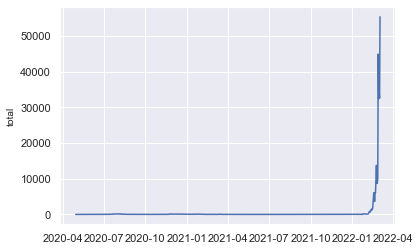

In [73]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x=nopendingdiffdf.index, y='total',
             data=nopendingdiffdf)

To see a particular time frame

<Axes: ylabel='total'>

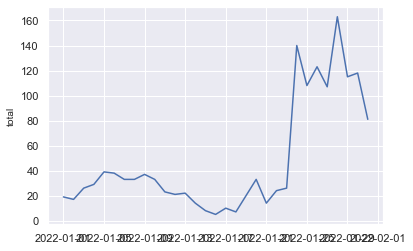

In [74]:
sns.lineplot(x=nopendingdiffdf.loc['2022-01-01':'2022-01-31'].index, y='total',
             data=nopendingdiffdf.loc['2022-01-01':'2022-01-31'])

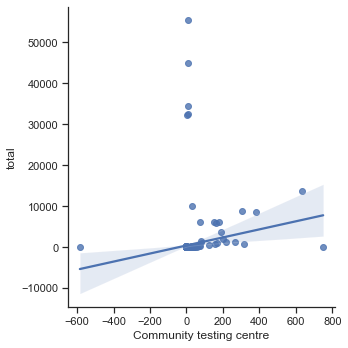

In [75]:
sns.set_theme(style="ticks")

# Show the results of a linear regression within each dataset
sns.lmplot(x="Community testing centre", y="total", data=nopendingdiffdf)

## Dimension Reduction with PCA

In [78]:
from sklearn import decomposition

nonnullcolumns = [
  'Cases fulfilling the reporting criteria of COVID-19',
  'Enhanced laboratory surveillance in public hospitals', 
  'Diagnosis / Enhanced surveillance in private hospitals and clinics', 
  'Enhanced surveillance for asymptomatic inbound travelers',
  'total'
]

X = nopendingdiffdf[nonnullcolumns].dropna()

# Apply principal component analysis for dimension reduction first
pca = decomposition.PCA(n_components=2)
pca.fit(X)
nopendingdiff2d = pca.transform(X)

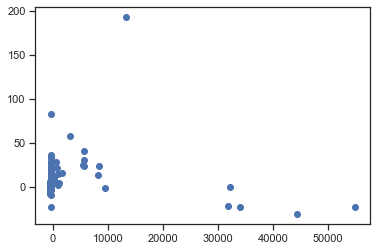

In [79]:
import matplotlib.pyplot as plt

plt.scatter(nopendingdiff2d[:,0], nopendingdiff2d[:,1])


### Show data point for specific time frame.

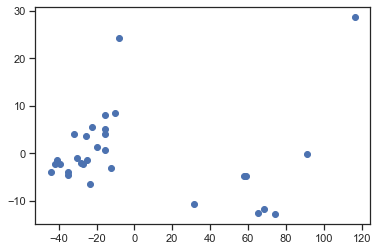

In [80]:
data = nopendingdiffdf[nonnullcolumns].dropna().loc['2022-01-01':'2022-01-31']

pca.fit(data)
data2d = pca.transform(data)

plt.scatter(data2d[:,0], data2d[:,1])

# Regression

## Linear

Regression model slope:     [1.24852618e-16]
Regression model intercept: 7.105427357601005e-16


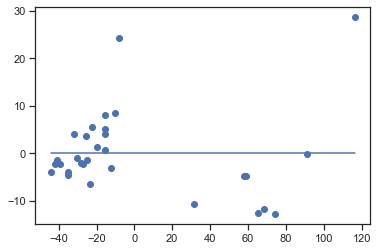

In [81]:
from sklearn.linear_model import LinearRegression

x = data2d[:,0]
y = data2d[:,1]

linearreg = LinearRegression(fit_intercept=True)

# np.newaxis is to add a new dimension
linearreg.fit(x[:, np.newaxis], y)

print("Regression model slope:    ", linearreg.coef_)
print("Regression model intercept:", linearreg.intercept_)

xfit = np.array([x.min(), x.max()])
yfit = linearreg.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

# Clustering

## KMeans

/Users/kennycheng/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


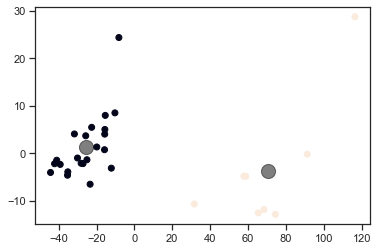

In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(data2d)
y_kmeans = kmeans.predict(data2d)
plt.scatter(data2d[:, 0], data2d[:, 1], c=y_kmeans)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);